## AML Project : ScanSense AI
****
The objective of this project is to come up with an analytical solution to detect fruits or vegetables in a plastic bag which can enable easy and quick checkouts for customers in grocery stores

In [ ]:
# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Import libraries
****

In [ ]:
import os
import kagglehub
import shutil
import random
from PIL import Image, ImageFilter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, classification_report
import cv2
import numpy as np
from torchvision.models import resnet18
from torchvision.models.segmentation import deeplabv3_resnet50


### Download Data
****

In [ ]:
# Function to download datasets using kagglehub
def download_datasets(base_folder):
    # Define the folder path in Google Drive
    #base_folder = '/content/AML_project_data'

    # Create the folder if it doesn't exist
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)

    print("Downloading datasets...")

    # Download fruit and vegetable dataset
    fruit_dataset_path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")
    print(f"Fruit and Vegetable Dataset downloaded to: {fruit_dataset_path}")

    # Move the dataset to the base folder
    fruit_target_path = os.path.join(base_folder, "fruit_and_vegetable_dataset")
    shutil.move(fruit_dataset_path, fruit_target_path)

    return fruit_dataset_path



In [ ]:
# Ensure the base folder is in Google Drive
google_drive_folder = '/content/drive/My Drive/AML_project_data'

if not os.path.exists(google_drive_folder):
    os.makedirs(google_drive_folder)

# Set the base folder to the Google Drive path
base_folder = google_drive_folder



In [ ]:
# Download the datasets
fruit_path= download_datasets(base_folder)

# Validate paths
print("\nDownloaded Dataset Paths:")
print(f"Fruit Dataset Path: {fruit_path}")

100%|██████████| 1.98G/1.98G [00:13<00:00, 153MB/s]

Extracting files...


Fruit and Vegetable Dataset downloaded to: /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8


Error: Destination path '/content/drive/My Drive/AML_project_data/fruit_and_vegetable_dataset/8' already exists

### Data Augmentation
****
Generate additional images with Gaussian blur and transformations including rotation and zoom in/out
### `Run the below cell only once`


In [ ]:
# Path to the train dataset
train_dataset_path = "/content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/train"
test_dataset_path = "/content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/test"
validation_dataset_path = "/content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/validation"

# Define the transformations
def apply_transformations(image):
    """Apply random transformations to the image."""
    # Choose a random level of Gaussian blur
    blur_radius = random.uniform(1, 5)
    image = image.filter(ImageFilter.GaussianBlur(blur_radius))

    # Randomly rotate the image (optional)
    if random.choice([True, False]):
        angle = random.randint(-45, 45)  # Random rotation between -45 to 45 degrees
        image = image.rotate(angle, expand=True)

    # Randomly zoom in/out (optional)
    if random.choice([True, False]):
        scale = random.uniform(0.8, 1.2)  # Zoom scale between 0.8x to 1.2x
        w, h = image.size
        new_w, new_h = int(w * scale), int(h * scale)

        # Use Image.Resampling.LANCZOS instead of Image.ANTIALIAS
        image = image.resize((new_w, new_h), Image.Resampling.LANCZOS)

        # Crop or pad to original size
        if scale < 1.0:  # Pad if zoomed out
            pad_w, pad_h = (w - new_w) // 2, (h - new_h) // 2
            image = Image.new("RGB", (w, h), (0, 0, 0))
            image.paste(image, (pad_w, pad_h))
        else:  # Crop if zoomed in
            left, top = (new_w - w) // 2, (new_h - h) // 2
            image = image.crop((left, top, left + w, top + h))
    return image

# Iterate through all folders in the train dataset
for label_folder in os.listdir(train_dataset_path):
    folder_path = os.path.join(train_dataset_path, label_folder)
    print("Processing:", folder_path)
    # Skip if it's not a folder
    if not os.path.isdir(folder_path):
        continue

    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".jpeg", ".png"))]

    # Randomly choose 10 images
    chosen_images = random.sample(image_files, min(10, len(image_files)))

    for image_file in chosen_images:
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path).convert("RGB")

        # Apply transformations
        transformed_image = apply_transformations(image)

        # Save the transformed image
        base_name, ext = os.path.splitext(image_file)
        new_image_name = f"{base_name}_transformed{ext}"
        new_image_path = os.path.join(folder_path, new_image_name)
        transformed_image.save(new_image_path)

# Iterate through all folders in the test dataset
for label_folder in os.listdir(test_dataset_path):
    folder_path = os.path.join(test_dataset_path, label_folder)
    print("Processing:", folder_path)
    # Skip if it's not a folder
    if not os.path.isdir(folder_path):
        continue

    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".jpeg", ".png"))]

    # Randomly choose 10 images
    chosen_images = random.sample(image_files, min(10, len(image_files)))

    for image_file in chosen_images:
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path).convert("RGB")

        # Apply transformations
        transformed_image = apply_transformations(image)

        # Save the transformed image
        base_name, ext = os.path.splitext(image_file)
        new_image_name = f"{base_name}_transformed{ext}"
        new_image_path = os.path.join(folder_path, new_image_name)
        transformed_image.save(new_image_path)

# Iterate through all folders in the validation dataset
for label_folder in os.listdir(validation_dataset_path):
    folder_path = os.path.join(validation_dataset_path, label_folder)
    print("Processing:", folder_path)
    # Skip if it's not a folder
    if not os.path.isdir(folder_path):
        continue

    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".jpeg", ".png"))]

    # Randomly choose 10 images
    chosen_images = random.sample(image_files, min(10, len(image_files)))

    for image_file in chosen_images:
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path).convert("RGB")

        # Apply transformations
        transformed_image = apply_transformations(image)

        # Save the transformed image
        base_name, ext = os.path.splitext(image_file)
        new_image_name = f"{base_name}_transformed{ext}"
        new_image_path = os.path.join(folder_path, new_image_name)
        transformed_image.save(new_image_path)


print("New images with transformations created successfully!")



### Image Segmentation & Transfer Learning for classification
****
Image segmentation helps to focus on the most relevant regions in the image which can help the image detection method to be more accurate.

For transfer learning, we will be using ResNet, a pretrained image detection model to tune it identify fruits and vegetables

In [ ]:

# Paths to datasets
FRUIT_PATHS = {
    "train": r"/content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/train",
    "test": r"/content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/test",
    "validation": r"/content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/validation"
}

# Segmentation function
def segment_image(image_path):
    # Generalized HSV ranges for fruits and vegetables
    target_colors = [
        (np.array([0, 40, 40]), np.array([10, 255, 255])),
        (np.array([160, 40, 40]), np.array([180, 255, 255])),
        (np.array([20, 50, 50]), np.array([40, 255, 255])),
        (np.array([30, 30, 30]), np.array([85, 255, 255])),
        (np.array([120, 40, 40]), np.array([155, 255, 255])),
        (np.array([0, 0, 180]), np.array([180, 50, 255])),
        (np.array([10, 40, 40]), np.array([25, 255, 150]))
    ]

    image = cv2.imread(image_path)
    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return None  # Or handle the error

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    combined_mask = np.zeros(hsv.shape[:2], dtype=np.uint8)

    for lower, upper in target_colors:
        mask = cv2.inRange(hsv, lower, upper)
        combined_mask = cv2.bitwise_or(combined_mask, mask)

    kernel = np.ones((5, 5), np.uint8)
    refined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    refined_mask = cv2.dilate(refined_mask, kernel, iterations=2)

    contours, _ = cv2.findContours(refined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(refined_mask)
    for contour in contours:
        if cv2.contourArea(contour) > 1000:
            cv2.drawContours(final_mask, [contour], -1, 255, thickness=cv2.FILLED)

    segmented_image = cv2.bitwise_and(image, image, mask=final_mask)
    return segmented_image

# Custom Dataset Class with Segmentation
class SegmentedDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root))

        for label_idx, class_name in enumerate(self.classes):
            class_folder = os.path.join(root, class_name)
            if os.path.isdir(class_folder):
                for file in os.listdir(class_folder):
                    if file.endswith((".jpg", ".jpeg", ".png")):
                        self.image_paths.append(os.path.join(class_folder, file))
                        self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Apply segmentation
        segmented_image = segment_image(image_path)
        # Check if segmentation failed and skip this image if it did
        if segmented_image is None:
            print(f"Error: Segmentation failed for {image_path}. Skipping...")
            # Return a dummy image and label to avoid stopping the training loop
            # This dummy image will be ignored during training
            dummy_image = torch.zeros(3, 128, 128)
            return dummy_image, -1

        segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        if self.transform:
            segmented_image = self.transform(transforms.ToPILImage()(segmented_image))

        return segmented_image, label

# Data Preparation
def load_data(batch_size=32):
    # Data augmentation for training dataset
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, hue=0.3)], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # No data augmentation for validation and test datasets
    test_val_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load datasets with segmentation
    train_dataset = SegmentedDataset(root=FRUIT_PATHS["train"], transform=train_transform)
    test_dataset = SegmentedDataset(root=FRUIT_PATHS["test"], transform=test_val_transform)
    val_dataset = SegmentedDataset(root=FRUIT_PATHS["validation"], transform=test_val_transform)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    num_classes = len(train_dataset.classes)
    return train_loader, test_loader, val_loader, num_classes

# Transfer Learning Model using ResNet18
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Training and Evaluation
def train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs=10, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} - Training...")
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []

        for images, labels in train_loader:
            # Skip dummy images added for failed segmentations
            valid_indices = labels != -1
            images, labels = images[valid_indices].to(device), labels[valid_indices].to(device)

            # Skip if there are no valid images in the batch
            if images.shape[0] == 0:
                continue

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = accuracy_score(train_labels, train_preds)
        print(f"Training Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")

        # Validation
        print("Validating...")
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(classification_report(val_labels, val_preds))

    # Testing
    print("Testing...")
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(test_labels, test_preds))

# Save the Model
def save_model(model, path="/content/drive/My Drive/AML_project_data/self_checkout_model_augmented_segmented.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved at {path}")

# Main Function
if __name__ == "__main__":
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameters
    epochs = int(input("Enter number of epochs (default 10): ") or 10)
    batch_size = int(input("Enter batch size (default 32): ") or 32)

    # Load datasets
    train_loader, test_loader, val_loader, num_classes = load_data(batch_size=batch_size)

    # Build, train, and evaluate the model
    model = TransferLearningModel(num_classes=num_classes).to(device)
    train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs=epochs, device=device)

    # Save the trained model
    save_model(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25 - Training...
Error: Could not load image from /content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/train/bell pepper/Image_56.jpg
Error: Segmentation failed for /content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/train/bell pepper/Image_56.jpg. Skipping...
Training Loss: 2.7281, Accuracy: 0.2640
Validating...
Validation Accuracy: 0.3635
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.68      0.72      0.70        18
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        18
           4       0.86      0.60      0.71        20
           5       0.41      0.56      0.47        16
           6       1.00      0.67      0.80        18
           7       0.44      0.67      0.53        18
           8       0.55      0.30      0.39        20
           9       0.33      0.10      0.15        20
          10       0.16

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error: Could not load image from /content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/train/bell pepper/Image_56.jpg
Error: Segmentation failed for /content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/train/bell pepper/Image_56.jpg. Skipping...
Training Loss: 1.9668, Accuracy: 0.4464
Validating...
Validation Accuracy: 0.4586
              precision    recall  f1-score   support

           0       0.86      0.33      0.48        18
           1       0.50      0.72      0.59        18
           2       1.00      0.05      0.10        20
           3       0.00      0.00      0.00        18
           4       0.85      0.85      0.85        20
           5       1.00      0.31      0.48        16
           6       0.72      0.72      0.72        18
           7       0.67      0.11      0.19        18
           8       1.00      0.40      0.57        20
           9       1.00      0.05      0.10        20
          10       0.27      0.60      0.37     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error: Could not load image from /content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/train/bell pepper/Image_56.jpg
Error: Segmentation failed for /content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/train/bell pepper/Image_56.jpg. Skipping...
Training Loss: 1.7603, Accuracy: 0.5047
Validating...
Validation Accuracy: 0.5583
              precision    recall  f1-score   support

           0       0.75      0.33      0.46        18
           1       0.67      0.67      0.67        18
           2       0.93      0.65      0.76        20
           3       0.78      0.39      0.52        18
           4       1.00      0.45      0.62        20
           5       0.50      0.50      0.50        16
           6       0.46      0.72      0.57        18
           7       0.40      0.56      0.47        18
           8       0.80      0.60      0.69        20
           9       0.53      0.50      0.51        20
          10       1.00      0.85      0.92     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error: Could not load image from /content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/train/bell pepper/Image_56.jpg
Error: Segmentation failed for /content/drive/MyDrive/AML_project_data/fruit_and_vegetable_dataset/train/bell pepper/Image_56.jpg. Skipping...
Training Loss: 1.5421, Accuracy: 0.5471
Validating...
Validation Accuracy: 0.6810
              precision    recall  f1-score   support

           0       0.73      0.44      0.55        18
           1       1.00      0.67      0.80        18
           2       0.88      0.75      0.81        20
           3       0.89      0.44      0.59        18
           4       0.94      0.85      0.89        20
           5       0.59      0.81      0.68        16
           6       1.00      0.39      0.56        18
           7       0.80      0.22      0.35        18
           8       0.86      0.90      0.88        20
           9       0.80      0.60      0.69        20
          10       0.85      0.55      0.67     

### New inference pipeline
****
The below code can be used to test the outputs of the model for any individual images

<ipython-input-119-1bf3f6cc6121>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Prediction 1: banana (68.53%)
Prediction 2: watermelon (28.54%)


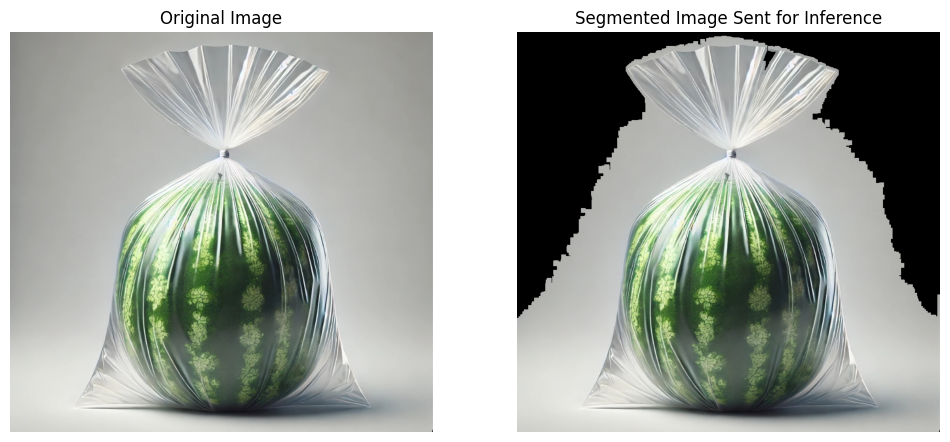

In [ ]:
import torch
from torchvision import transforms
import numpy as np

def inference_pipeline(image_path, model, class_names, device='cuda'):
    """
    Perform inference on an individual image.

    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): Trained PyTorch model.
        class_names (list): List of class names corresponding to the labels.
        device (str): Device to perform inference on ('cuda' or 'cpu').

    Returns:
        None: Prints the top 2 predictions with probabilities.
    """
    # Segmentation and Preprocessing
    segmented_image = segment_image(image_path)
    if segmented_image is None:
        print(f"Error: Segmentation failed for {image_path}.")
        return

    # Convert the segmented image to RGB and preprocess
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(transforms.ToPILImage()(segmented_image)).unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

    # Get top 2 predictions
    top2_prob, top2_indices = torch.topk(probabilities, 2)
    for i in range(2):
        print(f"Prediction {i+1}: {class_names[top2_indices[i]]} ({top2_prob[i].item() * 100:.2f}%)")

    # Display the original and segmented images
    import matplotlib.pyplot as plt
    original_image = cv2.imread(image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image_rgb)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("Segmented Image Sent for Inference")
    plt.imshow(segmented_image)
    plt.axis("off")
    plt.show()

# Usage example
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the trained model
    model_path = "/content/drive/My Drive/AML_project_data/self_checkout_model_augmented_segmented.pth"
    model = TransferLearningModel(num_classes=34)  # Adjust num_classes based on your dataset
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

    # Define class names (should match your dataset)
    class_names = sorted(os.listdir(FRUIT_PATHS["train"]))

    # Test the inference pipeline on a single image
    test_image_path = "/content/drive/MyDrive/AML_project_data/final_validation_data/35.Watermelon.jpeg"  # Replace with your test image path
    inference_pipeline(test_image_path, model, class_names, device=device)
